In [ ]:
%reload_ext autoreload
%autoreload 2

import os
import sys
from re import match
from time import gmtime, sleep, strftime

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import boto3
import matplotlib.pyplot as plt
import numpy as np
import sagemaker
import tensorflow as tf
from hydra import compose, core, initialize
from omegaconf import OmegaConf
from sagemaker.tensorflow import TensorFlowModel
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)
from tqdm import tqdm

sys.path.append(os.path.dirname(os.getcwd()))
from src import model_utils

## Hydra

In [2]:
# Reset global config https://github.com/facebookresearch/hydra/blob/0.11_branch/hydra/_internal/hydra.py#L41-L42
core.global_hydra.GlobalHydra.instance().clear()
initialize(
    version_base="1.2", config_path="../src/config", job_name="fine_tune_notebook"
)
config = OmegaConf.to_container(compose(config_name="main"), resolve=True)

## S3

In [3]:
s3 = boto3.client("s3")

train_val_path = {
    "train": sagemaker.inputs.TrainingInput(
        s3_data=f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train',
        distribution="FullyReplicated",
        s3_data_type="S3Prefix",
    ),
    "val": sagemaker.inputs.TrainingInput(
        s3_data=f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/val',
        distribution="FullyReplicated",
        s3_data_type="S3Prefix",
    ),
}
train_val_path

{'train': <sagemaker.inputs.TrainingInput at 0x7f73ebbae680>,
 'val': <sagemaker.inputs.TrainingInput at 0x7f74c009e5f0>}

## Sagemaker

In [4]:
sagemaker_session = sagemaker.Session(default_bucket=config["s3_bucket"])
sagemaker_session

sm_boto3 = boto3.client("sagemaker")
role = sagemaker.get_execution_role()

## Fine-Tuning

### Tensorflow Estimator

Test fine-tuning script locally on CPUs:

In [5]:
!sudo rm -rf /tmp/tmp*

In [8]:
fine_tune_testing_hyperparameters = {}
fine_tune_testing_estimators = {}
for pretrained_name in ["vgg19", "resnet50v2", "xception"]:
    fine_tune_testing_estimators[pretrained_name] = TensorFlow(
        # Entry point
        entry_point=config["fine_tune"]["entry_point"],
        source_dir=config["src_dir_path"],
        py_version=config["py_version"],
        framework_version=config["framework_version"],
        # Sagemaker
        role=role,
        instance_type="local",
        instance_count=config["fine_tune"]["instance_count"],
        model_dir=config["model_dir"],
        code_location=config["code_location"],
        output_path=config["output_path"],
        volume_size=config["volume_size"],
        hyperparameters={
            "test_mode": 1,
            "distributed_multi_worker": 0,
            "use_focal_loss": 0,
        },
    )

    fine_tune_testing_hyperparameters[pretrained_name] = {
        # Data augmentation parameters
        "random_flip_mode": "horizontal",
        "random_rotation_factor": 0.15,
        "random_contrast_factor": 0.15,
        "random_zoom_height_factor": 0.15,
        "random_zoom_width_factor": 0.15,
        # Architecture parameters
        "dense_num_layers": 1,
        "dense_units_0": 8,
        "dense_units_1": 8,
        "dense_units_2": 8,
        "dense_weight_decay": 1e-5,
        "dense_dropout_rate": 0.3,
        # Optimization, loss, and fit parameters
        "adam_initial_lr": 1e-3,
        "adam_beta_1": 0.9,
        "adam_beta_2": 0.999,
        "adam_clipnorm": 0.1,
        "loss_gamma": 0.0,
        "loss_alpha": 0.0,
        "fit_epochs": 2,
        # Pretraining parameters
        "pretrained_name": pretrained_name,
        "pretrained_pooling": "avg",
    }

In [ ]:
fine_tune_testing_estimators["vgg19"].set_hyperparameters(
    **fine_tune_testing_hyperparameters["vgg19"]
)

fine_tune_testing_estimators["vgg19"].fit(train_val_path)

In [ ]:
fine_tune_testing_estimators["resnet50v2"].set_hyperparameters(
    **fine_tune_testing_hyperparameters["resnet50v2"]
)

fine_tune_testing_estimators["resnet50v2"].fit(train_val_path)

In [ ]:
fine_tune_testing_estimators["xception"].set_hyperparameters(
    **fine_tune_testing_hyperparameters["xception"]
)

fine_tune_testing_estimators["xception"].fit(train_val_path)

### Hyperparameter Tuning

In [26]:
fine_tune_tf_estimator = TensorFlow(
    # Entry point
    entry_point=config["fine_tune"]["entry_point"],
    source_dir=config["src_dir_path"],
    py_version=config["py_version"],
    framework_version=config["framework_version"],
    # Sagemaker
    role=role,
    instance_type=config["fine_tune"]["instance_type"],
    instance_count=config["fine_tune"]["instance_count"],
    model_dir=config["model_dir"],
    code_location=config["code_location"],
    output_path=config["output_path"],
    volume_size=config["volume_size"],
    base_job_name=config["fine_tune"]["base_job_name"],
    sagemaker_session=sagemaker_session,
    # Distributed
    distribution={"multi_worker_mirrored_strategy": {"enabled": True}},
    # # Spot training
    # max_run=config['max_run'],
    # max_wait=config['max_run'], # Equal or greater than max_run
    # max_retry_attempts=config['max_retry_attempts'],
    # use_spot_instances=config['use_spot_instances'],
    # checkpoint_s3_uri=os.path.join(config['checkpoint_s3_uri'], 'fine_tune'),
    hyperparameters={
        "test_mode": 0,
        "distributed_multi_worker": 1,
        "use_focal_loss": 0,
    },
)
fine_tune_tf_estimator

In [27]:
fine_tune_search_space = {
    # Data augmentation parameters
    "random_contrast_factor": ContinuousParameter(min_value=0.1, max_value=1.0),
    "random_flip_mode": CategoricalParameter(
        values=["horizontal", "vertical", "horizontal_and_vertical"]
    ),
    "random_rotation_factor": ContinuousParameter(min_value=0.1, max_value=0.7),
    "random_zoom_height_factor": ContinuousParameter(min_value=0.1, max_value=0.7),
    "random_zoom_width_factor": ContinuousParameter(min_value=0.1, max_value=0.7),
    # Architecture parameters
    "dense_num_layers": IntegerParameter(min_value=1, max_value=3),
    "dense_units_0": IntegerParameter(min_value=128, max_value=1024),
    "dense_units_1": IntegerParameter(min_value=128, max_value=1024),
    "dense_units_2": IntegerParameter(min_value=128, max_value=1024),
    "dense_weight_decay": ContinuousParameter(
        min_value=1e-6, max_value=1e-1, scaling_type="Logarithmic"
    ),
    "dense_dropout_rate": ContinuousParameter(min_value=0.0, max_value=0.5),
    # Optimization, loss, and fit parameters
    "adam_initial_lr": ContinuousParameter(
        min_value=1e-4, max_value=1e-1
    ),  # Smaller learning rate since large gradient updates may lead to overfitting
    "adam_beta_1": ContinuousParameter(min_value=0.7, max_value=0.999),
    "adam_beta_2": ContinuousParameter(min_value=0.8, max_value=0.999),
    "adam_clipnorm": ContinuousParameter(min_value=1e-2, max_value=1.0),
    "loss_alpha": ContinuousParameter(0.1, 0.9),
    "loss_gamma": ContinuousParameter(0.5, 2.0),
    "fit_epochs": IntegerParameter(min_value=10, max_value=20),
    # Pretraining parameters
    "pretrained_name": CategoricalParameter(values=["vgg19", "resnet50v2", "xception"]),
    "pretrained_pooling": CategoricalParameter(values=["avg", "max", "none"]),
}

fine_tune_objective_metric_name = "accuracy"
fine_tune_objective_type = "Maximize"
fine_tune_metric_definitions = [
    {
        "Name": fine_tune_objective_metric_name,
        "Regex": "Best validation accuracy after fine-tuning: ([0-9\\.]+)",
    }
]

In [28]:
fine_tune_hpo_tuner = HyperparameterTuner(
    estimator=fine_tune_tf_estimator,
    objective_metric_name=fine_tune_objective_metric_name,
    hyperparameter_ranges=fine_tune_search_space,
    metric_definitions=fine_tune_metric_definitions,
    strategy="Bayesian",
    objective_type=fine_tune_objective_type,
    max_jobs=15,
    max_parallel_jobs=1,
    base_tuning_job_name=config["fine_tune"]["base_tuning_job_name"],
)

In [ ]:
fine_tune_hpo_tuner.fit(train_val_path)

Results of optimization:

In [5]:
fine_tune_hpo_analytics = sagemaker.HyperparameterTuningJobAnalytics(
    fine_tune_hpo_tuner.latest_tuning_job.name
)

fine_tune_hpo_results = fine_tune_hpo_analytics.dataframe()

fine_tune_hpo_results.sort_values("FinalObjectiveValue", ascending=False).head(10)

adam_beta_1  adam_beta_2  adam_clipnorm  adam_initial_lr  \
1      0.996352     0.982779       0.220048         0.000417   
2      0.964890     0.955383       0.059105         0.004175   
8      0.989768     0.989098       0.049618         0.002622   
12     0.952435     0.897395       0.107403         0.000903   
5      0.903420     0.996908       0.421228         0.000230   
13     0.997581     0.988354       0.017446         0.000509   
11     0.894704     0.990433       0.268914         0.038668   
6      0.947267     0.986781       0.159803         0.010375   
10     0.915733     0.998509       0.642096         0.001145   
3      0.990306     0.990479       0.064660         0.032869   

    dense_dropout_rate  dense_num_layers  dense_units_0  dense_units_1  \
1             0.055999               1.0          702.0          580.0   
2             0.204974               2.0          482.0          273.0   
8             0.206613               2.0          172.0          491.0   
12            0.446057               1.0          684.0          586.0   
5             0.270717               3.0          198.0          277.0   
13            0.089643               3.0          152.0          698.0   
11            0.395380               1.0          210.0          154.0   
6             0.339051               1.0          132.0          287.0   
10            0.032774               2.0          771.0          749.0   
3             0.247127               3.0          585.0          742.0   

    dense_units_2  dense_weight_decay  ...           random_flip_mode  \
1           268.0            0.000001  ...                 "vertical"   
2           552.0            0.000004  ...  "horizontal_and_vertical"   
8           505.0            0.000500  ...  "horizontal_and_vertical"   
12          763.0            0.001024  ...                 "vertical"   
5           747.0            0.000002  ...               "horizontal"   
13          248.0            0.001602  ...  "horizontal_and_vertical"   
11          918.0            0.000076  ...  "horizontal_and_vertical"   
6           816.0            0.000129  ...  "horizontal_and_vertical"   
10          153.0            0.000541  ...               "horizontal"   
3           721.0            0.000002  ...               "horizontal"   

    random_rotation_factor  random_zoom_height_factor  \
1                 0.551290                   0.107062   
2                 0.475893                   0.331455   
8                 0.287152                   0.245847   
12                0.642157                   0.495929   
5                 0.182432                   0.206527   
13                0.286258                   0.114621   
11                0.288985                   0.457709   
6                 0.283649                   0.385204   
10                0.126213                   0.343393   
3                 0.108703                   0.127990   

   random_zoom_width_factor                         TrainingJobName  \
1                  0.470638  fine-tune-hpo-230808-2115-018-0667d1d7   
2                  0.470999  fine-tune-hpo-230808-2115-017-065f62b5   
8                  0.336454  fine-tune-hpo-230808-2115-011-a17b1ef1   
12                 0.346259  fine-tune-hpo-230808-2115-007-15de30dd   
5                  0.497756  fine-tune-hpo-230808-2115-014-4b9ff27a   
13                 0.379899  fine-tune-hpo-230808-2115-006-386e79c9   
11                 0.268337  fine-tune-hpo-230808-2115-008-dce1c657   
6                  0.293976  fine-tune-hpo-230808-2115-013-0b20db0b   
10                 0.373304  fine-tune-hpo-230808-2115-009-6cf84833   
3                  0.289673  fine-tune-hpo-230808-2115-016-13c5c335   

    TrainingJobStatus FinalObjectiveValue         TrainingStartTime  \
1           Completed            0.701008 2023-08-09 00:12:00+00:00   
2           Completed            0.664054 2023-08-09 00:02:51+00:00   
8           Completed            0.661814 2023-08-08 23:0

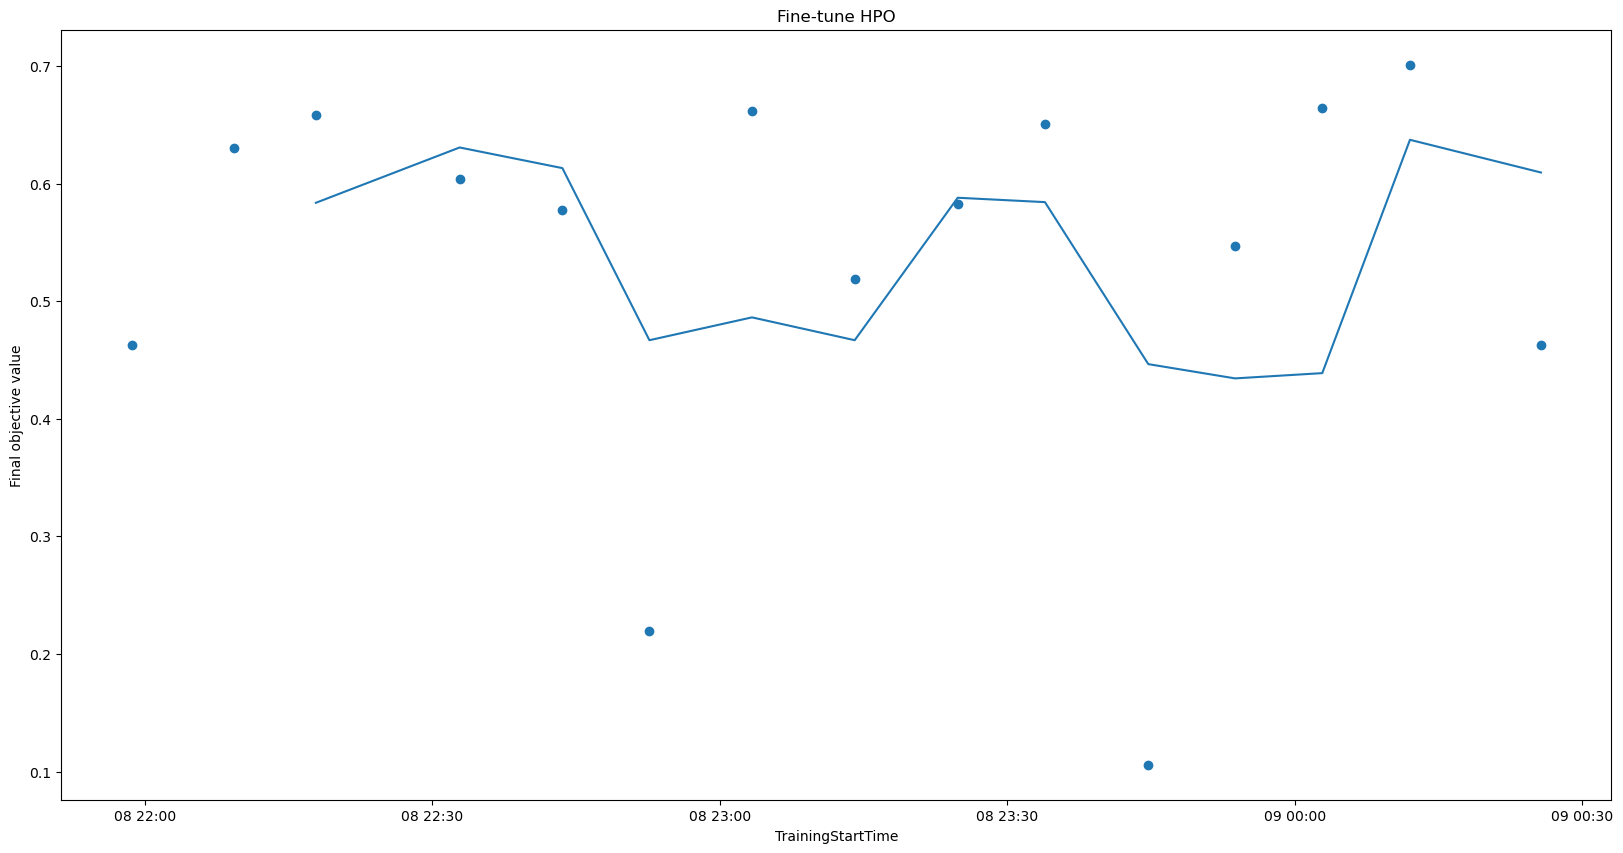

In [6]:
plt.figure(figsize=(20, 10))
# Remove missing values in TrainingStartTime
fine_tune_hpo_results.dropna(subset=["FinalObjectiveValue"], inplace=True)
# Sort by TrainingStartTime
fine_tune_hpo_results.sort_values("TrainingStartTime", inplace=True)
plt.scatter(
    fine_tune_hpo_results["TrainingStartTime"],
    fine_tune_hpo_results["FinalObjectiveValue"],
)
plt.plot(
    fine_tune_hpo_results["TrainingStartTime"],
    fine_tune_hpo_results["FinalObjectiveValue"].rolling(3).mean(),
)
plt.xlabel("TrainingStartTime")
plt.ylabel("Final objective value")
plt.title("Fine-tune HPO")
plt.show();

## Hyperparameter Visualization

In [ ]:
# List of hyperparameters
params = list(
    set(fine_tune_hpo_results.columns)
    - set(
        [
            "TrainingJobName",
            "TrainingJobStatus",
            "TrainingStartTime",
            "TrainingEndTime",
            "TrainingElapsedTimeSeconds",
            "FinalObjectiveValue",
        ]
    )
)
params.sort()

cat_params = ["pretrained_name", "pretrained_pooling", "random_flip_mode"]
num_params = list(set(params) - set(cat_params))

# Visualizer
viz = model_utils.TuningVisualizer(
    tune_data=fine_tune_hpo_results, cat_params=cat_params, num_params=num_params
)
viz

### Parallel Coordiante 

Hyperarameters related to optimization:

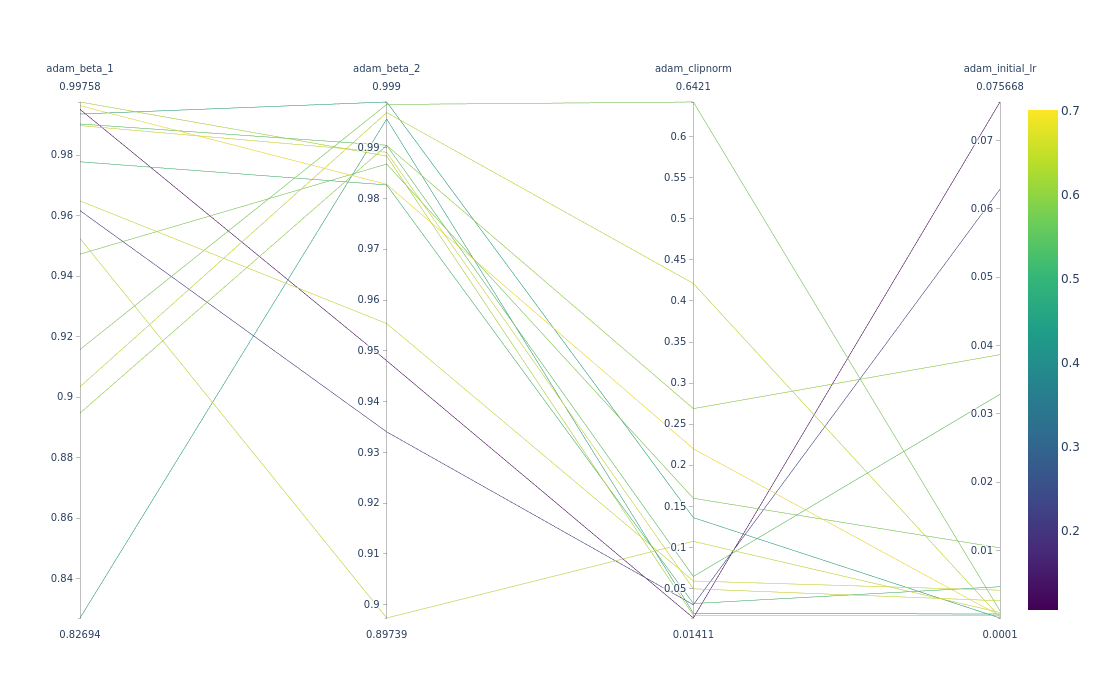

In [8]:
viz.plot_parallel_coordinate(
    columns=[param for param in params if match("^adam", param)],
    static=True,
    figsize=(1100, 700),
)

* Lower initial learning rate have higher objective values.

* Clipnorm and decay steps seem to be pretty random.

Dense layers hyperparameters:

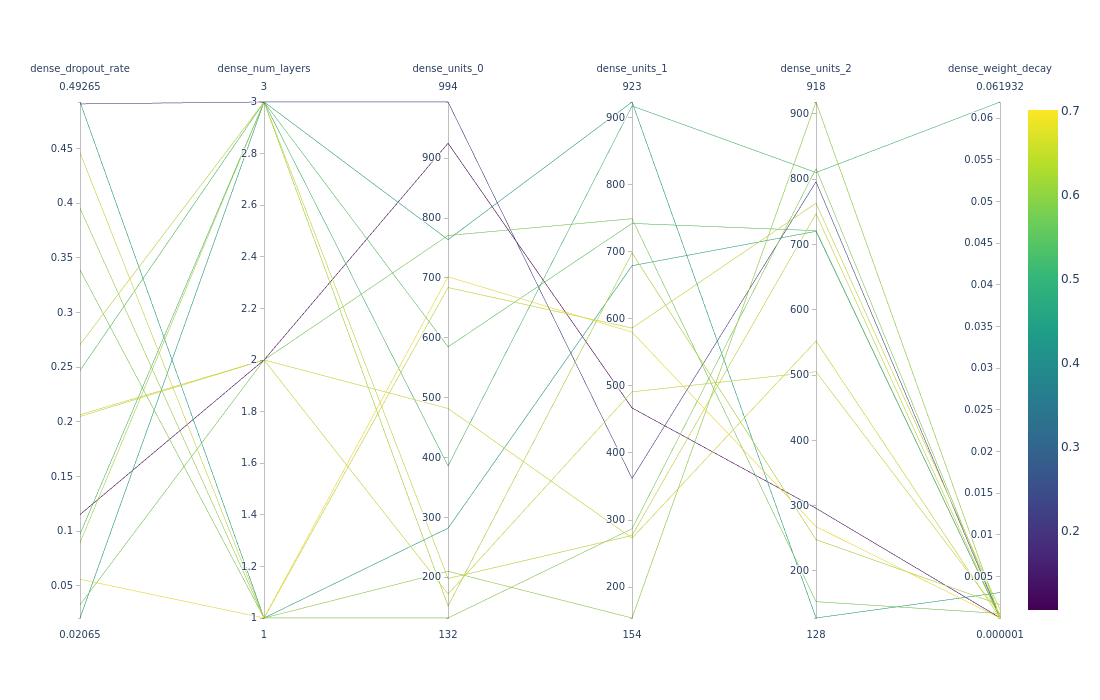

In [9]:
viz.plot_parallel_coordinate(
    columns=[param for param in params if match("^dense", param)],
    static=True,
    figsize=(1100, 700),
)

Pretrained hyperparameters:

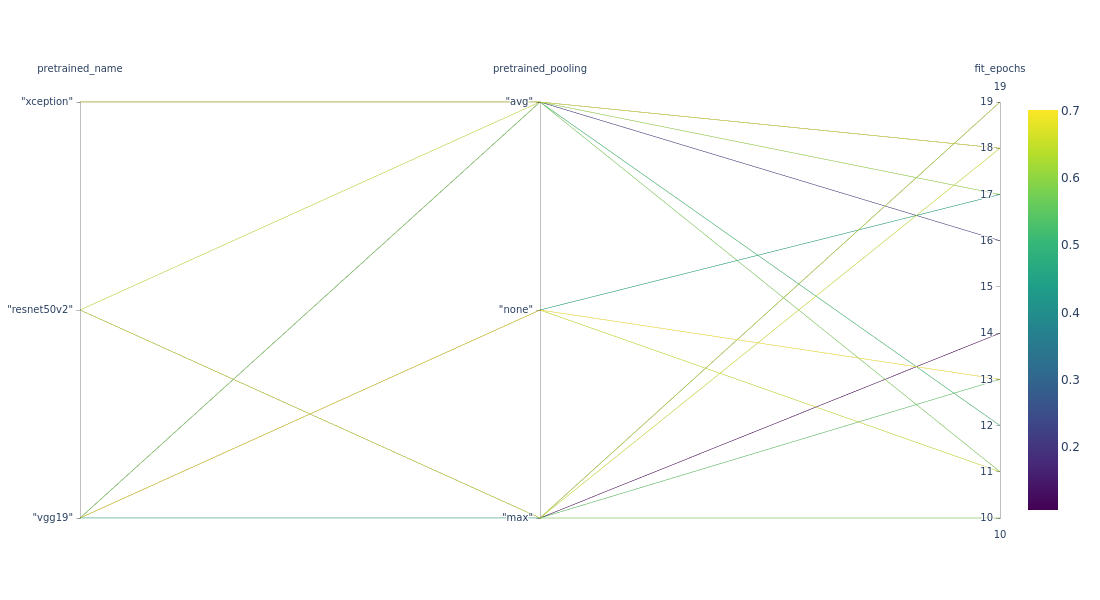

In [10]:
viz.plot_parallel_coordinate(
    columns=[param for param in params if match("^pretrained", param)] + ["fit_epochs"],
    static=True,
    figsize=(1100, 600),
)

Data augmentation hyperparameters:

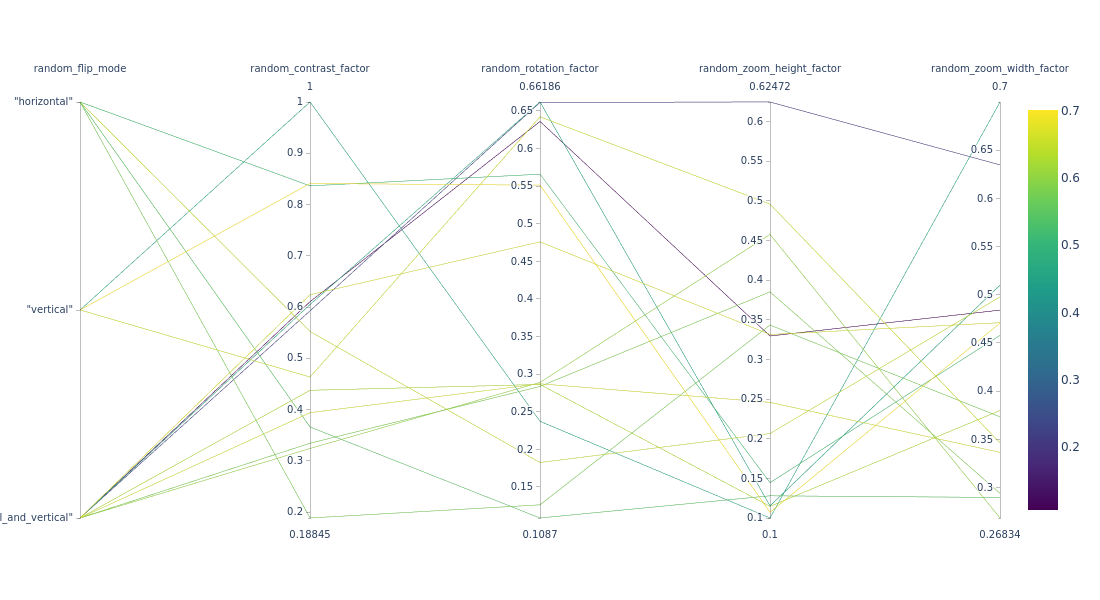

In [11]:
viz.plot_parallel_coordinate(
    columns=[param for param in params if match("^random", param)],
    static=True,
    figsize=(1100, 600),
)

## Inference

Deploy best model:

In [5]:
best_model_name = sm_boto3.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=hpo_tuner.latest_tuning_job.name
)["BestTrainingJob"]["TrainingJobName"]

# Obtain s3 path to model artifacts
best_model_s3_path = sm_boto3.describe_training_job(TrainingJobName=best_model_name)[
    "ModelArtifacts"
]["S3ModelArtifacts"]

print(f"Best model artifacts persisted at {best_model_s3_path}")

Best model artifacts persisted at s3://yang-ml-homepartners/scene-classification/models/fine-tune-hpo-230808-0918-001-a50b8b98/output/model.tar.gz


In [ ]:
best_model = TensorFlowModel(
    model_data=best_model_s3_path,
    role=role,
    framework_version=config["framework_version"],
    code_location=config["code_location"],
    sagemaker_session=sagemaker_session,
)

predictor = best_model.deploy(
    initial_instance_count=1,
    instance_type=config["fine_tune"]["inference_instance_type"],
    endpoint_name=config["fine_tune"]["endpoint_name"]
    + "-"
    + strftime("%H-%M-%S", gmtime()),
    container_startup_health_check_timeout=5 * 60,
)

----!

Load train, validation, and test set:

In [ ]:
train_dataset = model_utils.load_dataset(
    dir=train_val_path["train"].config["DataSource"]["S3DataSource"]["S3Uri"],
    batch_size=5,
).prefetch(tf.data.AUTOTUNE)

val_dataset = model_utils.load_dataset(
    dir=train_val_path["val"].config["DataSource"]["S3DataSource"]["S3Uri"],
    batch_size=5,
).prefetch(tf.data.AUTOTUNE)

test_dataset = model_utils.load_dataset(
    dir=f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/test', batch_size=5
).prefetch(tf.data.AUTOTUNE)

2023-08-08 20:14:58.638209: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Make predictions in batches:

In [11]:
train_pred_probs = []
y_train = []
X_train = []
for X_train_tf, y_train_tf in tqdm(train_dataset):
    # Predictions
    train_pred_probs.append(predictor.predict(X_train_tf.numpy())["predictions"])

    # Targets
    y_train.append(tf.math.argmax(y_train_tf, axis=1).numpy())

    # Images
    X_train.append(X_train_tf.numpy())

    sleep(1)

y_train = np.concatenate(y_train, axis=0)
X_train = np.concatenate(X_train, axis=0)
train_pred_probs = np.concatenate(train_pred_probs, axis=0)

  5%|▌         | 76/1426 [02:22<40:15,  1.79s/it] 

In [14]:
val_pred_probs = []
y_val = []
X_val = []
for X_val_tf, y_val_tf in tqdm(val_dataset):
    # Predictions
    val_pred_probs.append(predictor.predict(X_val_tf.numpy())["predictions"])

    # Targets
    y_val.append(tf.math.argmax(y_val_tf, axis=1).numpy())

    # Images
    X_val.append(X_val_tf.numpy())

    sleep(1)

y_val = np.concatenate(y_val, axis=0)
X_val = np.concatenate(X_val, axis=0)
val_pred_probs = np.concatenate(val_pred_probs, axis=0)

100%|██████████| 358/358 [11:39<00:00,  1.95s/it]


In [13]:
test_pred_probs = []
y_test = []
X_test = []
for X_test_tf, y_test_tf in tqdm(test_dataset):
    # Predictions
    test_pred_probs.append(predictor.predict(X_test_tf.numpy())["predictions"])

    # Targets
    y_test.append(tf.math.argmax(y_test_tf, axis=1).numpy())

    # Images
    X_test.append(X_test_tf.numpy())

    sleep(1)

y_test = np.concatenate(y_test, axis=0)
X_test = np.concatenate(X_test, axis=0)
test_pred_probs = np.concatenate(test_pred_probs, axis=0)

100%|██████████| 186/186 [06:08<00:00,  1.98s/it]


Write numpy probabilities matrices to s3:

In [ ]:
for name, (X, y), predicted_probs in zip(
    ["train", "val", "test"],
    [(X_train, y_train), (X_val, y_val), (X_test, y_test)],
    [train_pred_probs, val_pred_probs, test_pred_probs],
):
    filename = f"{name}.npz"

    np.savez(filename, X=X, y=y, predicted_probs=predicted_probs)

    s3_path = f's3://{config["s3_bucket"]}/{config["s3_key"]}/outputs'
    sagemaker.s3.S3Uploader.upload(filename, s3_path)

    os.remove(filename)

### Error Analysis

Load the predictions and data:

In [7]:
s3_path = f's3://{config["s3_bucket"]}/{config["s3_key"]}/outputs'
local_dir = "temp_data"
os.makedirs(local_dir, exist_ok=True)
data = {}
for name in ["train", "val", "test"]:
    local_path = os.path.join(local_dir, f"{name}.npz")
    sagemaker.s3.S3Downloader.download(os.path.join(s3_path, f"{name}.npz"), local_dir)

    with open(local_path, "rb") as f:
        dataset = np.load(f)
        data[name] = {
            "X": np.clip(dataset["X"].astype(np.int16), 0, 255),
            "y": dataset["y"],
            "predicted_probs": dataset["predicted_probs"],
        }

    # Remove the local file
    os.remove(local_path)

    print("Finished loading", name)

X_train, y_train, train_predicted_probs = (
    data["train"]["X"],
    data["train"]["y"],
    data["train"]["predicted_probs"],
)
X_val, y_val, val_predicted_probs = (
    data["val"]["X"],
    data["val"]["y"],
    data["val"]["predicted_probs"],
)
X_test, y_test, test_predicted_probs = (
    data["test"]["X"],
    data["test"]["y"],
    data["test"]["predicted_probs"],
)

os.rmdir(local_dir)

Finished loading train
Finished loading val
Finished loading test


Instantiate error analyzer:

In [ ]:
error_analyzer = model_utils.ErrorAnalyzer(
    y_true=y_train,
    images=X_train,
    y_pred=train_predicted_probs,
    label_mapping=config["class_label_map"],
)

#### Backyard

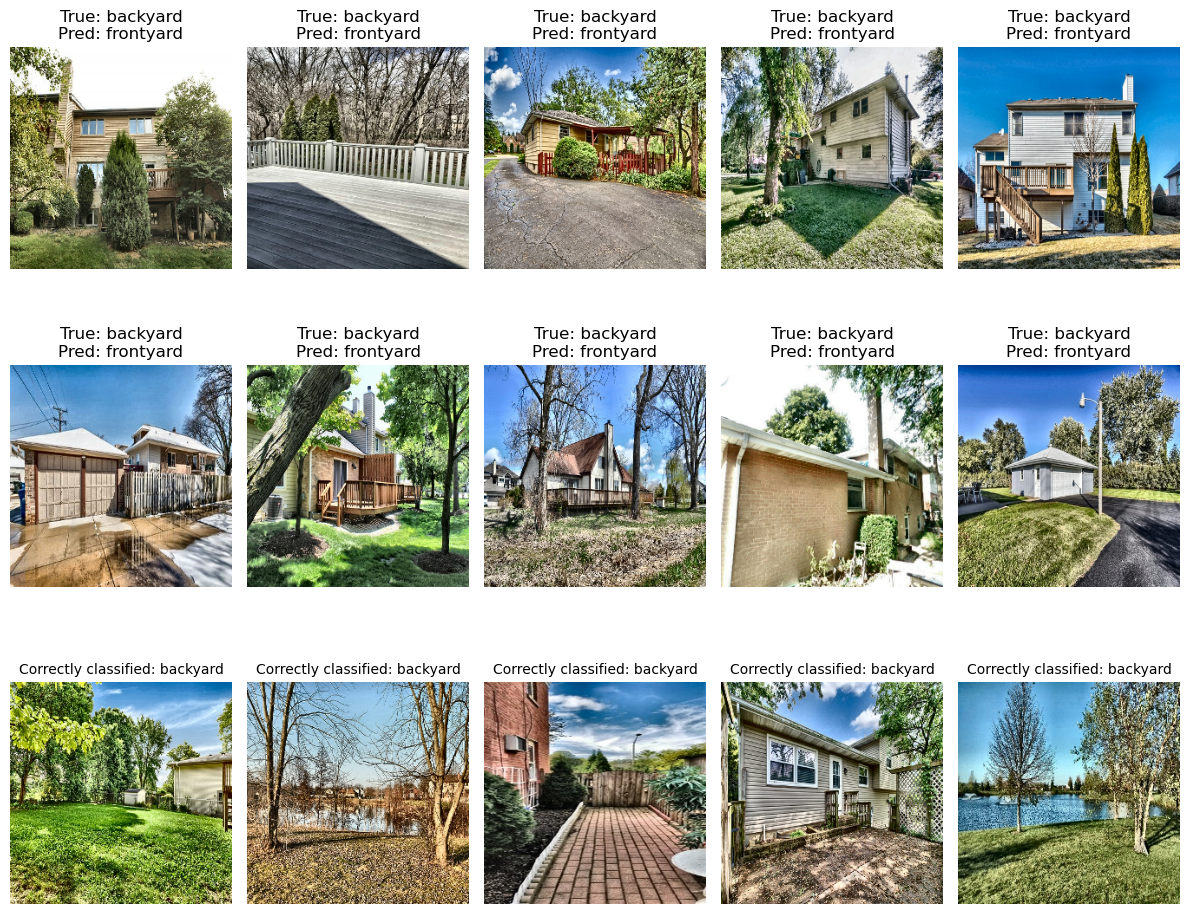

In [9]:
error_analyzer.plot_mis_clf(class_label="backyard", figsize=(12, 10));

* Many of the backyard and frontyards look very much alike, which can be hard to distinguish.

#### Bathroom

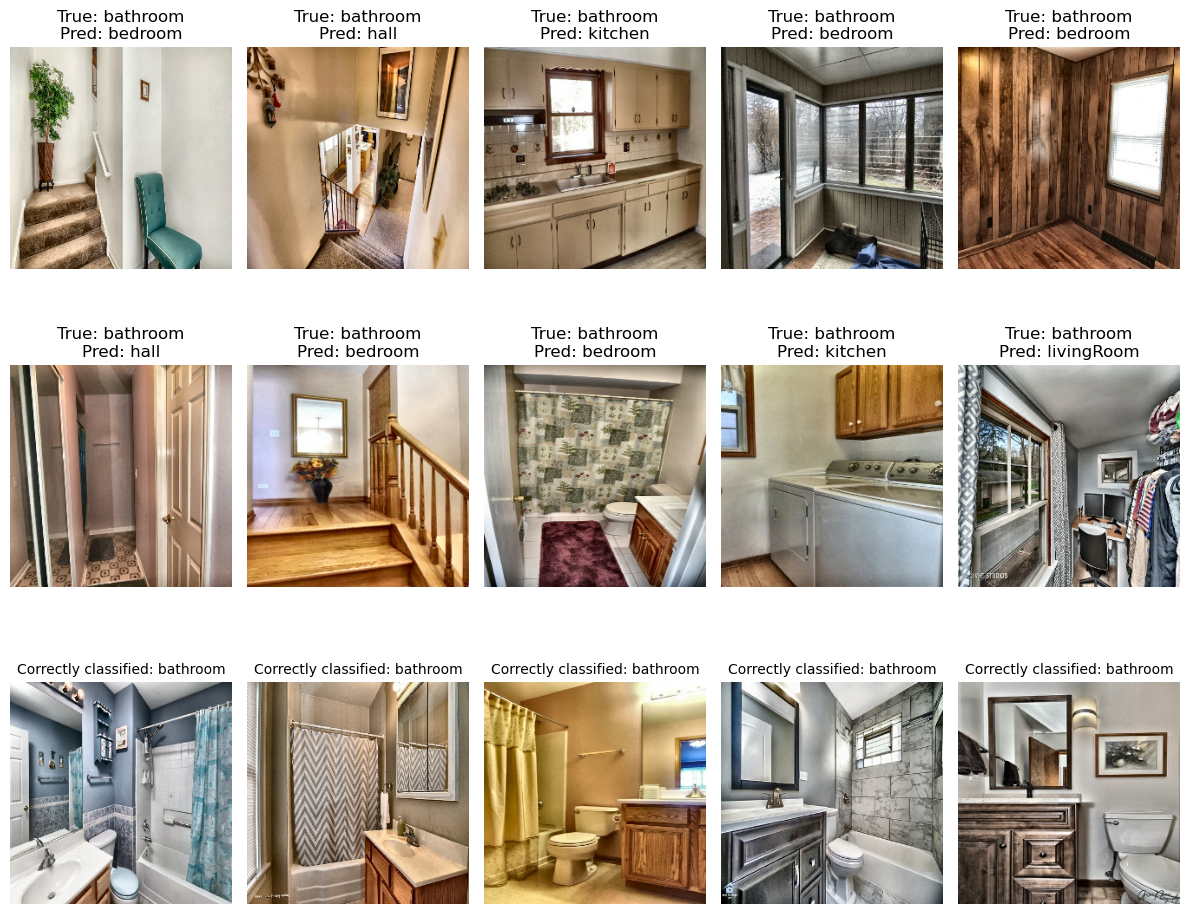

In [10]:
error_analyzer.plot_mis_clf(class_label="bathroom", figsize=(12, 10));

#### Dining Room

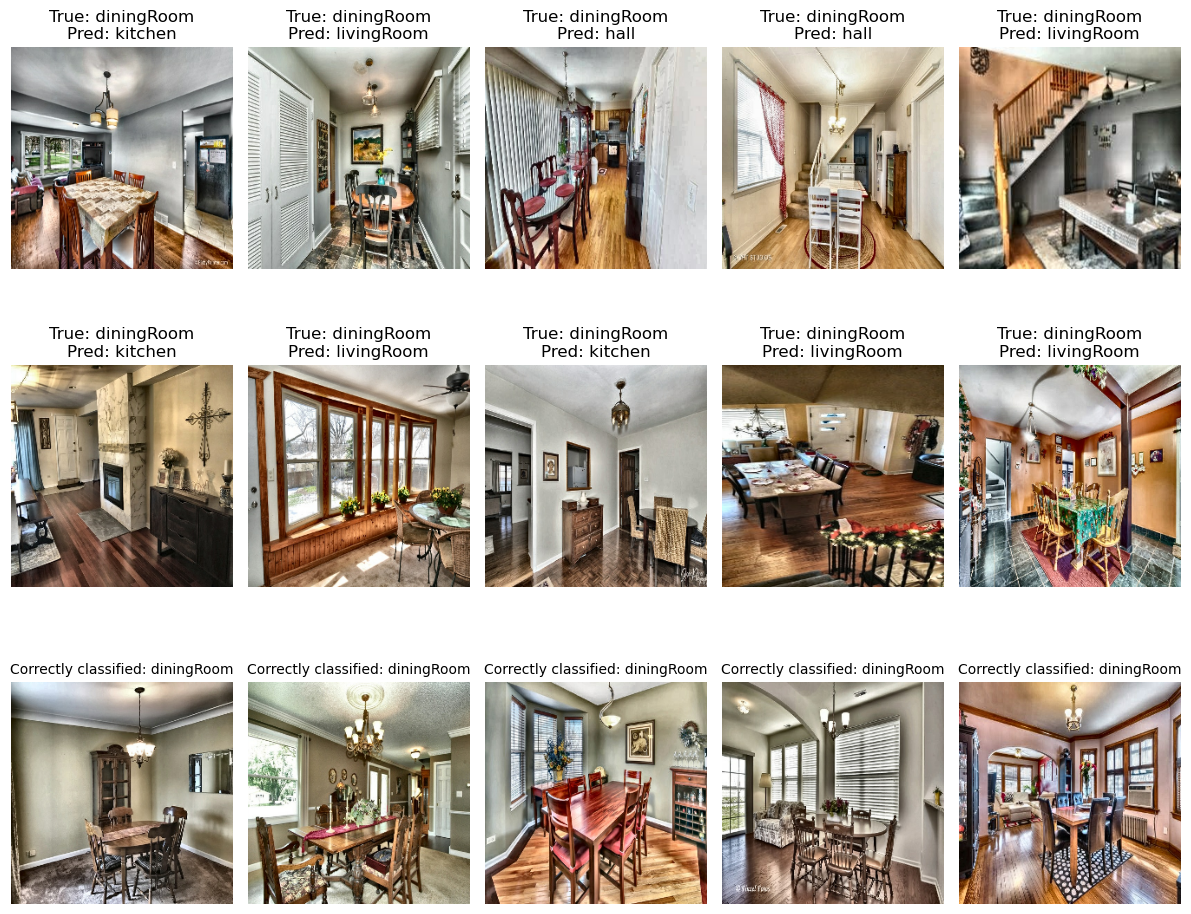

In [11]:
error_analyzer.plot_mis_clf(class_label="diningRoom", figsize=(12, 10));

#### Hall

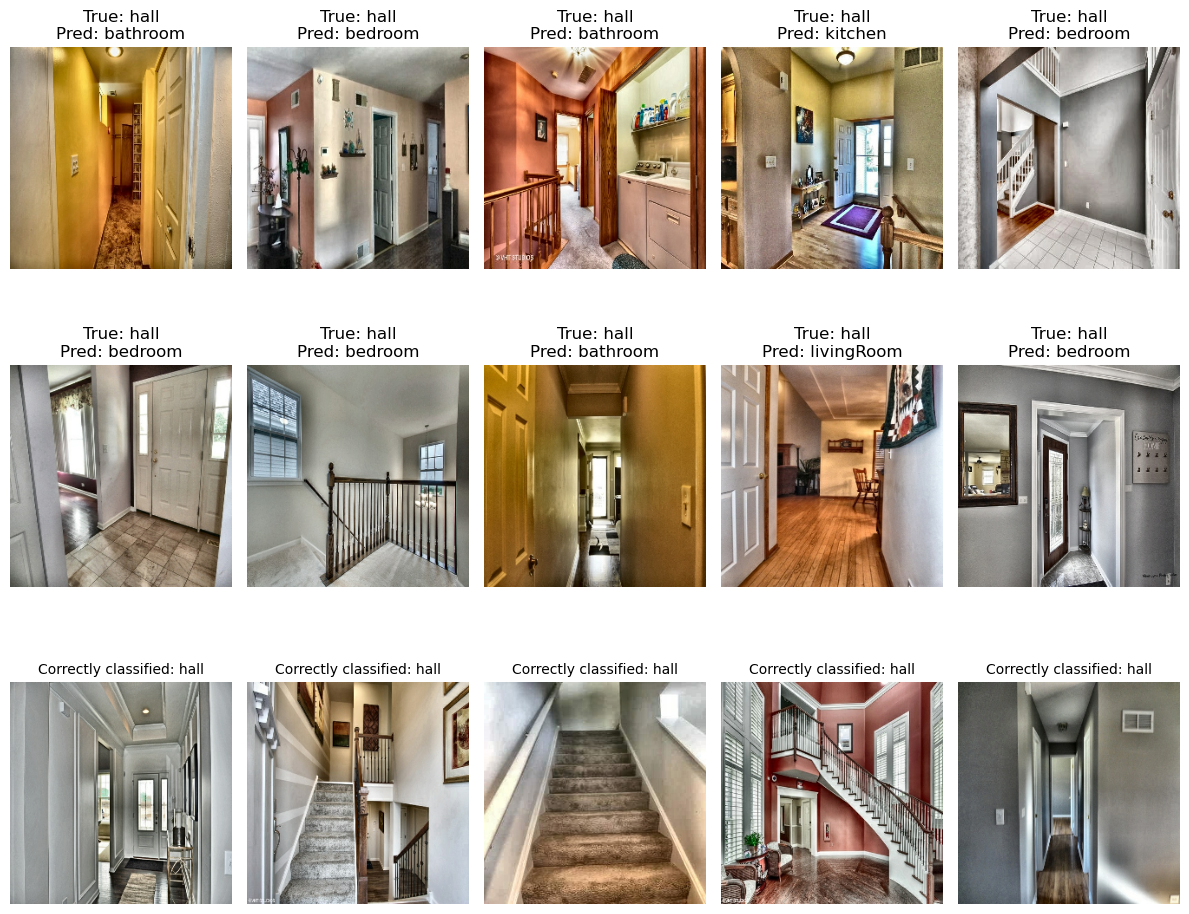

In [12]:
error_analyzer.plot_mis_clf(class_label="hall", figsize=(12, 10));

#### Plan

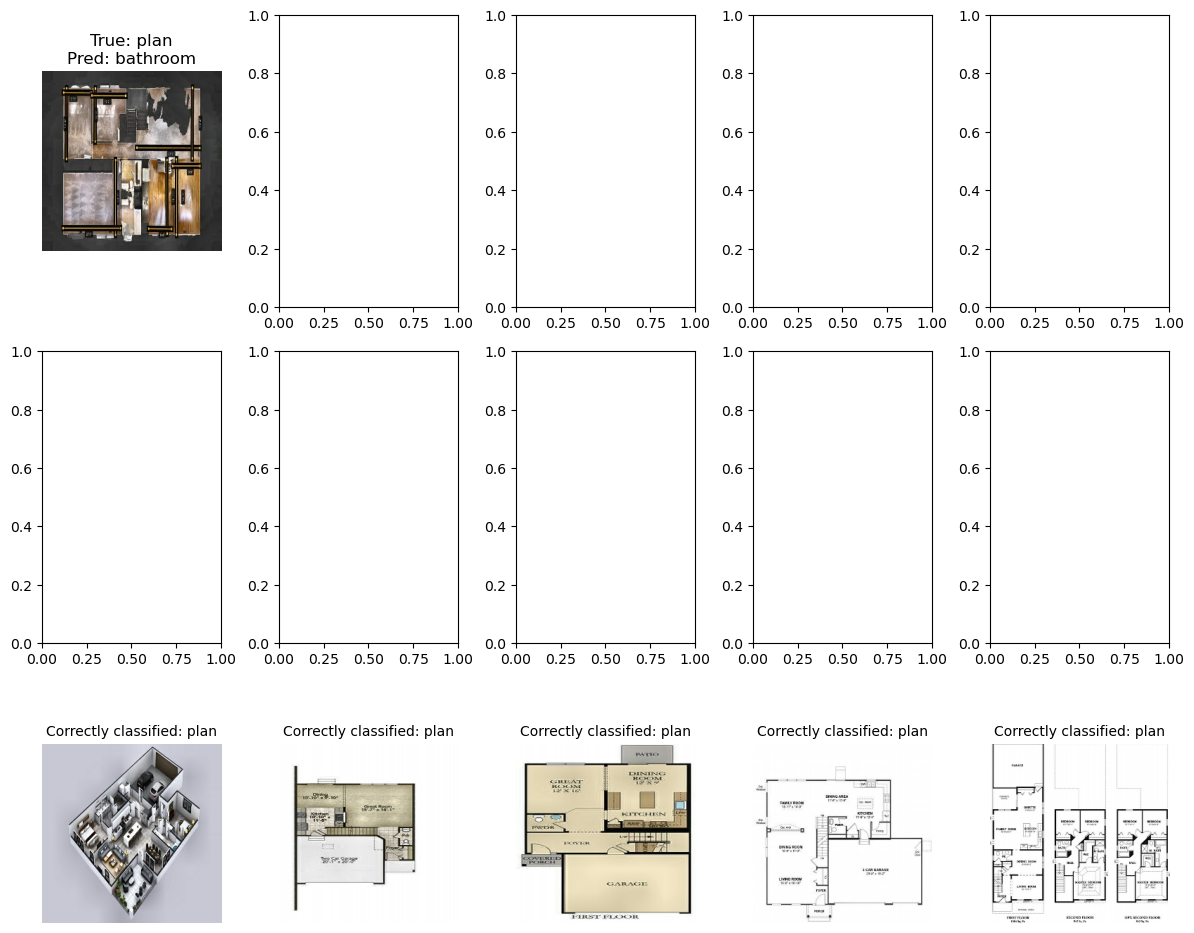

In [13]:
error_analyzer.plot_mis_clf(class_label="plan", figsize=(12, 10));

### Classification Report

In [15]:
config["class_label_map"]

{'backyard': 0,
 'bathroom': 1,
 'bedroom': 2,
 'diningRoom': 3,
 'frontyard': 4,
 'hall': 5,
 'kitchen': 6,
 'livingRoom': 7,
 'plan': 8}

### Training

In [ ]:
clf_report_train, agg_metrics_train = model_utils.classification_report(
    y_train,
    train_predicted_probs.argmax(axis=1),
    labels=list(config["class_label_map"]),
)

clf_report_train

precision  recall  specificity      f1  geometric_mean  \
backyard       0.8690  0.6634       0.9870  0.7524          0.8092   
bathroom       0.4254  0.7886       0.9813  0.5527          0.8797   
bedroom        0.3319  0.6466       0.9785  0.4386          0.7954   
diningRoom     0.6975  0.8980       0.9572  0.7851          0.9271   
frontyard      0.7162  0.8764       0.9447  0.7882          0.9099   
hall           0.6505  0.8370       0.8697  0.7320          0.8532   
kitchen        0.7212  0.8026       0.9579  0.7597          0.8768   
livingRoom     0.8424  0.3721       0.9766  0.5162          0.6028   
plan           0.9643  0.9926       0.9993  0.9783          0.9960   

            index_balanced_accuracy  support  
backyard                     0.6336    820.0  
bathroom                     0.7590    123.0  
bedroom                      0.6116    116.0  
diningRoom                   0.8545    706.0  
frontyard                    0.8223    979.0  
hall                         0.7255   1601.0  
kitchen                      0.7569    851.0  
livingRoom                   0.3415   1795.0  
plan                         0.9913    136.0

In [17]:
agg_metrics_train

{'avg_pre': 0.743,
 'avg_rec': 0.7063,
 'avg_spe': 0.9458,
 'avg_f1': 0.6931,
 'avg_geo': 0.8053,
 'avg_iba': 0.6518,
 'total_support': 7127}

### Validation

In [ ]:
clf_report_val, agg_metrics_val = model_utils.classification_report(
    y_val, val_predicted_probs.argmax(axis=1), labels=list(config["class_label_map"])
)

clf_report_val

precision  recall  specificity      f1  geometric_mean  \
backyard       0.8121  0.5874       0.9823  0.6817          0.7596   
bathroom       0.5000  0.6129       0.9892  0.5507          0.7786   
bedroom        0.3818  0.7000       0.9806  0.4941          0.8285   
diningRoom     0.6417  0.8701       0.9466  0.7386          0.9075   
frontyard      0.6981  0.9061       0.9377  0.7886          0.9218   
hall           0.6578  0.8055       0.8787  0.7242          0.8413   
kitchen        0.7817  0.8404       0.9682  0.8100          0.9020   
livingRoom     0.8130  0.4165       0.9678  0.5508          0.6349   
plan           0.9444  1.0000       0.9989  0.9714          0.9994   

            index_balanced_accuracy  support  
backyard                     0.5542    206.0  
bathroom                     0.5835     31.0  
bedroom                      0.6672     30.0  
diningRoom                   0.8173    177.0  
frontyard                    0.8470    245.0  
hall                         0.7026    401.0  
kitchen                      0.8033    213.0  
livingRoom                   0.3809    449.0  
plan                         0.9990     34.0

In [19]:
agg_metrics_val

{'avg_pre': 0.7314,
 'avg_rec': 0.7055,
 'avg_spe': 0.9445,
 'avg_f1': 0.694,
 'avg_geo': 0.8065,
 'avg_iba': 0.6508,
 'total_support': 1786}

### Test

In [ ]:
clf_report_test, agg_metrics_test = model_utils.classification_report(
    y_test, test_predicted_probs.argmax(axis=1), labels=list(config["class_label_map"])
)

clf_report_test

precision  recall  specificity      f1  geometric_mean  \
backyard       0.8866  0.6187       0.9861  0.7288          0.7811   
bathroom       0.4286  0.6000       0.9913  0.5000          0.7712   
bedroom        0.3226  0.6667       0.9770  0.4348          0.8071   
diningRoom     0.7326  0.9333       0.9421  0.8208          0.9377   
frontyard      0.7746  0.8594       0.9601  0.8148          0.9083   
hall           0.6485  0.8618       0.9087  0.7401          0.8850   
kitchen        0.8529  0.7838       0.9664  0.8169          0.8703   
livingRoom     0.7442  0.4211       0.9717  0.5378          0.6396   
plan           0.8750  1.0000       0.9978  0.9333          0.9989   

            index_balanced_accuracy  support  
backyard                     0.5877    139.0  
bathroom                     0.5715     10.0  
bedroom                      0.6311     15.0  
diningRoom                   0.8786    135.0  
frontyard                    0.8168    128.0  
hall                         0.7795    152.0  
kitchen                      0.7436    185.0  
livingRoom                   0.3866    152.0  
plan                         0.9980     14.0

In [21]:
agg_metrics_test

{'avg_pre': 0.7657,
 'avg_rec': 0.7441,
 'avg_spe': 0.9573,
 'avg_f1': 0.738,
 'avg_geo': 0.8365,
 'avg_iba': 0.6977,
 'total_support': 930}

## Clean up

In [78]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=predictor.endpoint_name)
sm_boto3.delete_model(ModelName=best_model.name)

{'ResponseMetadata': {'RequestId': 'a4004b2d-5559-4e12-a55e-12ad4009ff64',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a4004b2d-5559-4e12-a55e-12ad4009ff64',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 12 Jul 2023 15:58:44 GMT'},
  'RetryAttempts': 0}}

In [ ]:
sm_boto3.close()